In [13]:
import torch
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch import nn, optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [14]:
def train(model, train_loader, loss_fn, optimizer, device):
    # Prepare for training
    model.train()
    running_loss = 0
 
    # Use TQDM for interactive loading bars
    with tqdm(total=len(train_loader)) as pbar:
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Make image 3 channels and put on device
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = torch.cat([inputs, inputs, inputs], axis=1)

            # Run through model and update
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track loss and update progress
            running_loss += loss.item()
            pbar.update(1)

    return running_loss / len(train_loader)

In [15]:
# Function for the validation pass
def validation(model, val_loader, loss_fn, device):
    # Prepare for validating
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm(total=len(val_loader)) as pbar:
            for inputs, labels in iter(val_loader):
                # Make image 3 channels and put on device
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = torch.cat([inputs, inputs, inputs], axis=1)

                # Run through model
                outputs = model(inputs)

                # Track loss and update progress
                val_loss += loss_fn(outputs, labels).item()

                # Update accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                pbar.update(1)
            
    return val_loss / len(val_loader), correct / total

In [25]:
# An impure function to train our model
def fit(epochs):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        # Run training loop and validation loop
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss, accuracy = validation(model, test_loader, criterion, device)

        # Print result
        print("Epoch: {}/{}, Training Loss: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {}".format(epoch + 1, epochs, train_loss, val_loss, accuracy))
        print('-' * 20)

        # Record results
        train_losses.append(train_loss)
        test_losses.append(val_loss)
        accuracies.append(accuracy)    

    print("Finished Training")
    return train_losses, test_losses, accuracies

In [26]:
def plot_metrics(train_losses, test_losses, accuracies):
    # Creating one figure with two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 3))
    
    # Plot accuracies
    ax1.plot(acurracies)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Test Accuracy')
    
    # Plot NLL losses
    ax2.plot(train_losses, label='Train Losses')
    ax2.plot(test_losses, label='Test Losses')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('loss')
    ax2.set_title('NLL Loss')
    
    plt.show()

# Defining our Models and Datasets 

In [27]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [28]:
# Get model and pretrained weights
model = models.resnet34(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Initial Training
We use `pretrained=True` so that we can make use of some weights from ImageNet pretraining that PyTorch makes available to us. We are going to freeze these weights and replace the output layers to retrain this network for the new problem. The frozen layers can be thought of as an 'image feature extractor', which we are using rather than starting with random weights.

In [29]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False 

In [30]:
# Create output layers and replace output layers
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,256)),
    ('relu', nn.ReLU()),
    ('fc2', nn.Linear(256,64)),
    ('output', nn.LogSoftmax(dim=1))
]))
model.fc = fc
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
# Set criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)

In [32]:
# Get device and put model on device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Epoch: 1/10, Training Loss: 0.8908, Test Loss: 0.7391, Test Accuracy: 0.7366
--------------------



Epoch: 2/10, Training Loss: 0.7594, Test Loss: 0.7212, Test Accuracy: 0.7415
--------------------



Epoch: 3/10, Training Loss: 0.7264, Test Loss: 0.6974, Test Accuracy: 0.7441
--------------------



Epoch: 4/10, Training Loss: 0.6993, Test Loss: 0.6770, Test Accuracy: 0.7552
--------------------



Epoch: 5/10, Training Loss: 0.6854, Test Loss: 0.6789, Test Accuracy: 0.753
--------------------



Epoch: 6/10, Training Loss: 0.6676, Test Loss: 0.6744, Test Accuracy: 0.7628
--------------------



Epoch: 7/10, Training Loss: 0.6661, Test Loss: 0.6756, Test Accuracy: 0.7612
--------------------



Epoch: 8/10, Training Loss: 0.6551, Test Loss: 0.6686, Test Accuracy: 0.7638
--------------------



Epoch: 9/10, Training Loss: 0.6480, Test Loss: 0.6834, Test Accuracy: 0.7546
--------------------



Epoch: 10/10, Training Loss: 0.6456, Test Loss: 0.6640, Test Accuracy: 0.7635
--------------------
Finished Training


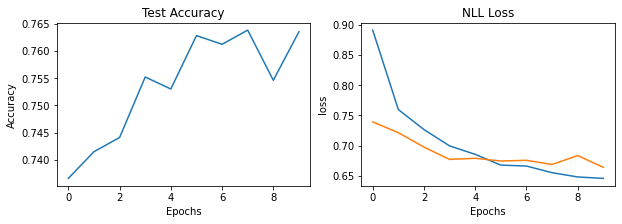

In [33]:
train_losses, test_losses, acurracies = fit(10)
plot_metrics(train_losses, test_losses, acurracies)

# Fine Tuning
We've now retrained this model for our problem, but we can do even better. The convolutional layers are still optimized for extracting features from the kind of images that imagenet has. After unfreezing the model we can retrain the whole network to adapt better to this problem, but we need to be careful to use a slower learning rate or we'll lose the pretraining that we already have.

In [34]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True 

In [35]:
# Reset our learning rate to make it slower
optimizer = optim.Adam(model.parameters(), lr=3e-5)


Epoch: 1/10, Training Loss: 0.4402, Test Loss: 0.3565, Test Accuracy: 0.8677
--------------------



Epoch: 2/10, Training Loss: 0.2962, Test Loss: 0.3080, Test Accuracy: 0.8912
--------------------



Epoch: 3/10, Training Loss: 0.2412, Test Loss: 0.2897, Test Accuracy: 0.8958
--------------------



Epoch: 4/10, Training Loss: 0.2031, Test Loss: 0.2767, Test Accuracy: 0.9046
--------------------



Epoch: 5/10, Training Loss: 0.1748, Test Loss: 0.2785, Test Accuracy: 0.9073
--------------------



Epoch: 6/10, Training Loss: 0.1506, Test Loss: 0.2818, Test Accuracy: 0.9069
--------------------



Epoch: 7/10, Training Loss: 0.1284, Test Loss: 0.2849, Test Accuracy: 0.9119
--------------------



Epoch: 8/10, Training Loss: 0.1123, Test Loss: 0.2872, Test Accuracy: 0.9115
--------------------



Epoch: 9/10, Training Loss: 0.0952, Test Loss: 0.3029, Test Accuracy: 0.9086
--------------------



Epoch: 10/10, Training Loss: 0.0813, Test Loss: 0.3204, Test Accuracy: 0.9118
--------------------
Finished Training


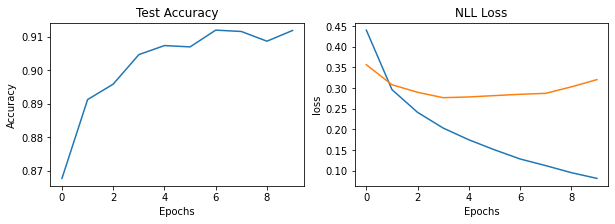

In [36]:
# Fine tune the layers at a slower learning rate
train_losses, test_losses, acurracies = fit(10)
plot_metrics(train_losses, test_losses, acurracies)